<a href="https://colab.research.google.com/github/milanpavikevik/GenreClassifier/blob/FINAL/k_means_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing libraries

In [ ]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')
%pylab inline
import os
import glob
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa.display

# Scikit learn
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix                   
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


# Prepare the Dataset

In [ ]:
# split dataset to train and test
train, test = train_test_split(dataset, test_size=0.25, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1428
Test: 477


In [ ]:
#extract the features for each sample
x_train = []
x_test = []

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

# the error is duet to KeyBoard Interruption :)

 60%|██████    | 857/1428 [15:59<10:56,  1.15s/it]

KeyboardInterrupt: ignored

# **Unsupervised Learning -> K-means**

In [ ]:
data_cluster = x_train + x_test
print(len(data_cluster))

1903


In [ ]:
# for each sample build a vector with 56 dimension
# using the mean of the 194 frames
clean_data = []
for row in data_cluster:
  ff = np.average(row,axis=1)
  clean_data.append(ff)

In [ ]:
#  build a dataframe with the set of vectors and the names for the dimensions
columns=[]
for i in range(1,41):
  columns.append('mfcc'+str(i))
columns.append('spec_cent')
columns.append('spec_bw')
columns.append('rolloff')
columns.append('zcr')
for i in range(1,13):
  columns.append('chroma_stft'+str(i))
print(columns)

['mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'mfcc21', 'mfcc22', 'mfcc23', 'mfcc24', 'mfcc25', 'mfcc26', 'mfcc27', 'mfcc28', 'mfcc29', 'mfcc30', 'mfcc31', 'mfcc32', 'mfcc33', 'mfcc34', 'mfcc35', 'mfcc36', 'mfcc37', 'mfcc38', 'mfcc39', 'mfcc40', 'spec_cent', 'spec_bw', 'rolloff', 'zcr', 'chroma_stft1', 'chroma_stft2', 'chroma_stft3', 'chroma_stft4', 'chroma_stft5', 'chroma_stft6', 'chroma_stft7', 'chroma_stft8', 'chroma_stft9', 'chroma_stft10', 'chroma_stft11', 'chroma_stft12']


In [ ]:
data_cluster = pd.DataFrame(clean_data,columns=columns)

In [ ]:
data_cluster.head(3)

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,mfcc21,mfcc22,mfcc23,mfcc24,mfcc25,mfcc26,mfcc27,mfcc28,mfcc29,mfcc30,mfcc31,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39,mfcc40,spec_cent,spec_bw,rolloff,zcr,chroma_stft1,chroma_stft2,chroma_stft3,chroma_stft4,chroma_stft5,chroma_stft6,chroma_stft7,chroma_stft8,chroma_stft9,chroma_stft10,chroma_stft11,chroma_stft12
0,-96.905903,105.420078,9.196734,20.461042,1.093264,-2.233801,15.504523,8.376716,-11.213575,11.617719,-9.003781,11.843130,-7.230007,-0.362574,0.346030,2.659777,-11.919343,-3.071745,-9.030289,1.442489,-2.218373,0.769538,2.428854,5.087428,-5.616440,4.021692,-7.568105,-0.788861,-0.248464,7.586385,0.411168,1.662515,-5.546914,-1.549652,-7.237640,-1.982090,-6.318865,-2.202368,-4.644432,-3.534993,2182.821468,2417.352758,4591.178595,0.088525,0.317324,0.444856,0.518002,0.319272,0.292050,0.224036,0.218873,0.152313,0.246320,0.479434,0.355520,0.425250
1,-45.525309,67.297826,-4.854013,50.224782,9.191722,10.447534,9.280453,13.644444,3.946446,12.042922,-1.673526,7.017927,-13.596566,-3.940305,-4.712344,3.028676,-3.109955,4.156270,1.173886,2.578910,-3.357594,6.954644,0.057073,0.320886,-7.641261,-2.025565,-1.162450,4.768170,-1.192298,2.095094,-1.816922,4.985875,-1.540052,5.079547,-3.040454,-2.770352,-6.998377,1.000392,-2.195579,5.355786,2744.353402,2614.304222,5578.542556,0.128634,0.492536,0.431542,0.579623,0.655160,0.882683,0.758330,0.540644,0.499461,0.545846,0.394540,0.388782,0.628540
2,-66.495270,132.353438,-2.471043,18.004029,-9.629349,8.661350,-8.233339,3.745808,-9.435837,4.901628,4.087920,7.022385,-7.190517,-0.802367,-3.785671,1.584085,-13.907062,-3.353776,-7.876321,-7.349519,-8.730346,0.411201,-8.537510,-0.508230,-4.386935,3.967444,-1.999989,-2.571531,-4.100672,3.347952,-1.754208,-2.627228,-9.261553,-7.989572,-8.408689,2.034311,-1.577178,-1.891416,-5.293878,0.398605,1498.261027,1990.967309,3131.749104,0.045647,0.468693,0.634708,0.330802,0.223080,0.333831,0.565494,0.432243,0.355090,0.337835,0.300784,0.384721,0.370521


In [ ]:
data_cluster.shape

(1903, 1)

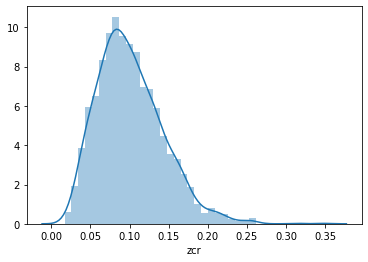

In [ ]:
import seaborn as sns

#plot the distribution of the ZCR dimension
plt2 = sns.distplot(data_cluster['zcr'])

In [ ]:
#Standardize the data
from sklearn import preprocessing
# Get column names first
names = data_cluster.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_data = scaler.fit_transform(data_cluster)
scaled_data = pd.DataFrame(scaled_data, columns=names)

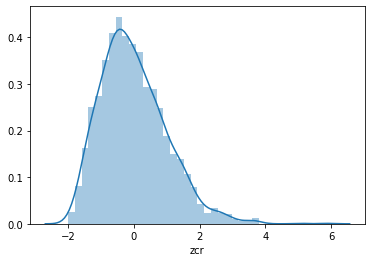

In [ ]:
# distribution of the standardized ZCR dimension
plt2 = sns.distplot(scaled_data['zcr'])

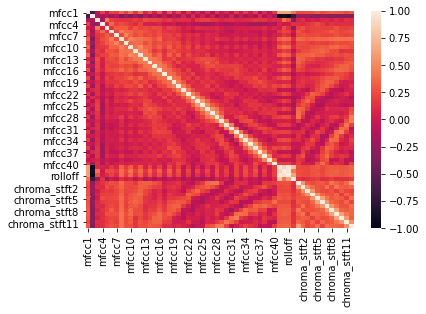

In [ ]:
# build the correlation matrix for the dimensions
corrMatrix = scaled_data.corr()
sns.heatmap(corrMatrix, annot=False,vmin=-1,vmax=1)
plt.show()

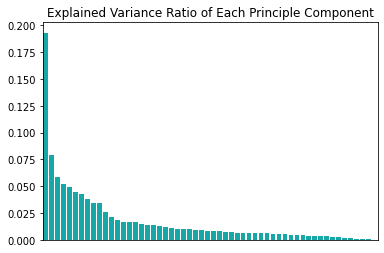

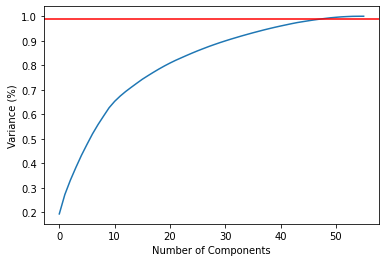

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
pca.fit(scaled_data) # find the PCA components
data_new = pca.transform(scaled_data)
plt.figure()
sns.barplot(x=np.arange(scaled_data.shape[1]),y=pca.explained_variance_ratio_, color="c")
plt.xticks([])
plt.title("Explained Variance Ratio of Each Principle Component")
plt.show()
plt.figure() # plot the explained variance per component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.99, color='r', linestyle='-') # draw te line y=0.99
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.show()


In [ ]:
# build PCA for the data with 56 components (ALL)
pca56 = PCA(n_components=56)
pca56.fit(scaled_data)
scaled_data = pca56.transform(scaled_data)

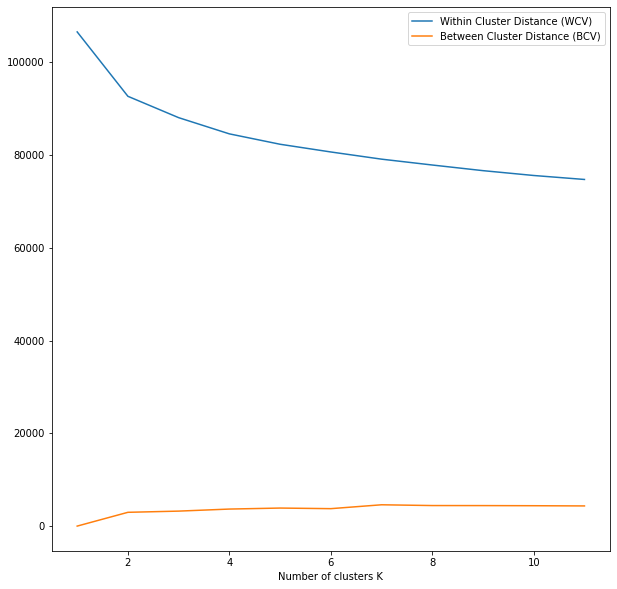

In [ ]:
# Try to estimate the value of K
# by running multiple K-means simulations
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

fig1 = plt.figure(figsize=(10, 10))
wcv = {}
bcv = {}

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k,max_iter=1000).fit(scaled_data)
    wcv[k] = kmeans.inertia_ 
    centers = kmeans.cluster_centers_
    BCV = 0
    for i in range(len(centers)):
        for j in range(len(centers)):
            BCV += distance.euclidean(centers[i], centers[j])**2
    if(k==1):
        bcv[1] = 0
    else:
        bcv[k] = BCV/(k*(k-1))*100
plt.plot(list(wcv.keys()), list(wcv.values()), label="Within Cluster Distance (WCV)")
plt.plot(list(bcv.keys()), list(bcv.values()), label="Between Cluster Distance (BCV)")
plt.xlabel("Number of clusters K")
plt.legend()
plt.show()

In [ ]:
# Fit the data to the K-means algorithm
estimator = KMeans(init='k-means++', n_clusters=9, random_state=42, n_init=100, max_iter=3000)
y_pred = estimator.fit_predict(scaled_data) 

In [ ]:
# define the T-SNE algorithm visualizer
tsne = TSNE(n_components=3, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_scale_results = tsne.fit_transform(scaled_data)
tsne_df_scale = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2', 'tsne3'])

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1903 samples in 0.016s...
[t-SNE] Computed neighbors for 1903 samples in 0.529s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1903
[t-SNE] Computed conditional probabilities for sample 1903 / 1903
[t-SNE] Mean sigma: 2.752806
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.440659
[t-SNE] KL divergence after 1500 iterations: 1.304912


In [ ]:
# feed the data to the T-SNE algorithm together with their respective cluster as a label
labels_tsne_scale = y_pred
clusters_tsne_scale = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

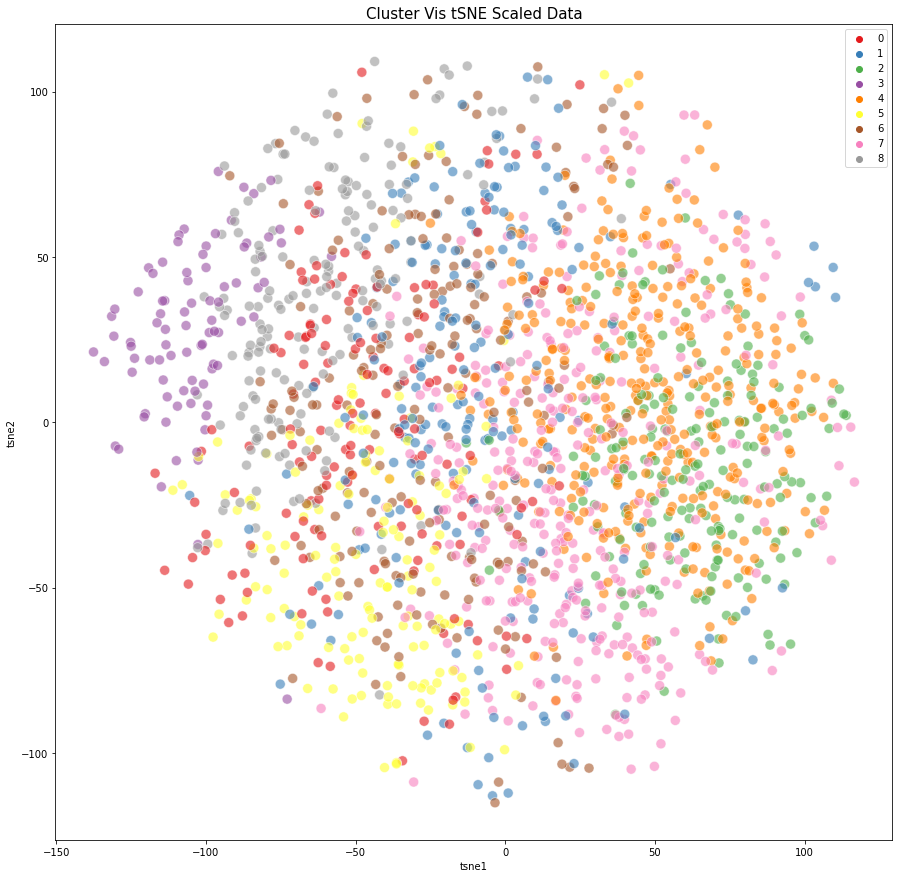

In [ ]:
# scatter plot for our data points in 2D
plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1],hue=labels_tsne_scale, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE Scaled Data', fontsize=15)
plt.legend()
plt.show()